In [1]:
import sys
sys.path.append("../..")

# Noisy Pendulum - Particle Filter Example

Estimate pendulum state with Particle Filter and Backward-simulation Particle Smoother as in Examples 7.1 and 11.1 of the book Bayesian Filtering and Smoothing


## Imports

### Standard imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, stats
import tqdm

### Helpers imports

In [3]:
from python.common_utilities import generate_pendulum, RandomState, rmse

### Plotting function

In [4]:
def plot(timeline, y, x1, label1, x2=None, label2=None):
    fig, axes = plt.subplots(ncols=2, figsize=(22, 10))
    axes[1].scatter(timeline, y, marker="o", label="Measurements", color="red", alpha=0.66)
    axes[1].plot(timeline, np.sin(x1[:, 0]), linestyle="dashdot", label=label1, color="blue")
                    
    axes[0].plot(x1[:, 0], x1[:, 1], label=label1, color="blue")
    
    if x2 is not None:
        axes[1].plot(timeline, np.sin(x2[:, 0]), linestyle="dashdot", label=label2, color="orange")
        axes[0].plot(x2[:, 0], x2[:, 1], label=label2, color="orange")
    else:
        axes[0].scatter(x1[0, 0], x1[0, 1], marker="x", color="orange", s=500)
        
    axes[0].set_xlabel("$x_0(t)$")
    axes[0].set_ylabel("$x_1(t)$")
    
    axes[1].set_xlabel("$t$")
    axes[1].set_ylabel("$\sin(x_0(t))$")
    
    axes[0].legend()
    axes[1].legend()


## Routine

Set the parameters:

In [5]:
dt = 0.01
g  = 9.81

In [6]:
Q  = 0.01 * np.array([[dt ** 3 / 3, dt ** 2 / 2], 
                       [dt ** 2 / 2, dt]])
R  = 0.1

In [7]:
x_0 = np.array([1.5, 0.])

## Simulate data

In [8]:
random_state = RandomState(1)
steps = 500

timeline, states, observations = generate_pendulum(x_0, g, Q, dt, R, steps, random_state)

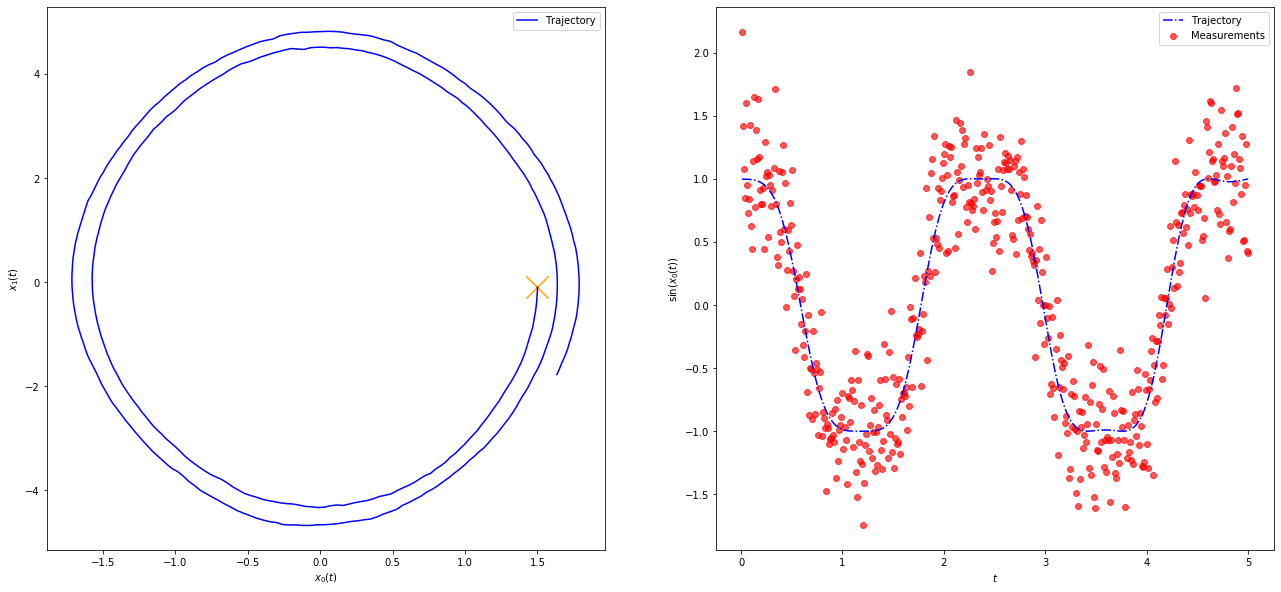

In [9]:
plot(timeline, observations, states, "Trajectory")

## Particle Filter

In [10]:
m_0 = np.array([1.6, 0.])  # Slightly off
P_0 = np.array([[0.1, 0.], 
                [0., 0.1]])

In [11]:
def stratified_resampling(w, random_state):
    """ Generate non decreasing numbers x_i between [0, 1]
    """
    n_particles = w.shape[0]
    z = random_state.rand(n_particles) + np.linspace(0., n_particles - 1., n_particles)
    us = z / n_particles
    cs = np.cumsum(w)
    idx = np.searchsorted(cs, us, side='left')

    return np.clip(idx, 0, n_particles - 1)


In [12]:
def normalise(w):
    """Normalises the positive vector w so that it sums to 1"""
    return w / np.sum(w, axis=-1, keepdims=True)

In [13]:
def particle_filter(m_0, P_0, g, Q, dt, R, observations, n_particles, random_state):
    steps = observations.shape[0]
    
    pf_states = np.empty((steps, 2, n_particles))
    
    chol_P0 = np.linalg.cholesky(P_0)
    chol_Q = np.linalg.cholesky(Q)
    state = m_0.reshape(2, 1) + np.matmul(chol_P0, random_state.randn(2, n_particles))
    
    w = np.full(n_particles, 1/n_particles)
    sqrt_R = np.sqrt(R)
    
    observation_dist = stats.norm(loc=0., scale=sqrt_R)
    ll = 0
    for i in range(steps):
        # Propagate through the dynamic model: cross-term update
        state[0, :], state[1, :] = state[0, :] + dt * state[1, :], state[1, :] - g * dt * np.sin(state[0, :])
        
        # Add the process noise
        state = state + np.matmul(chol_Q, random_state.randn(2, n_particles))

        # Compute the unnormalized importance weights
        obs = observations[i]
        w = observation_dist.pdf(obs - np.sin(state[0, :]))

        ll += np.log(np.mean(w))
        # Normalize them
        w = normalise(w)
        
        # Do resampling
        ind = stratified_resampling(w, random_state)
        state = state[:, ind]
        pf_states[i] = state
        
    return pf_states

In [14]:
n_particles = 1000
filtered_states = particle_filter(m_0, P_0, g, Q, dt, R, observations, n_particles, random_state)

In [15]:
pf_m = np.mean(filtered_states, axis=-1)

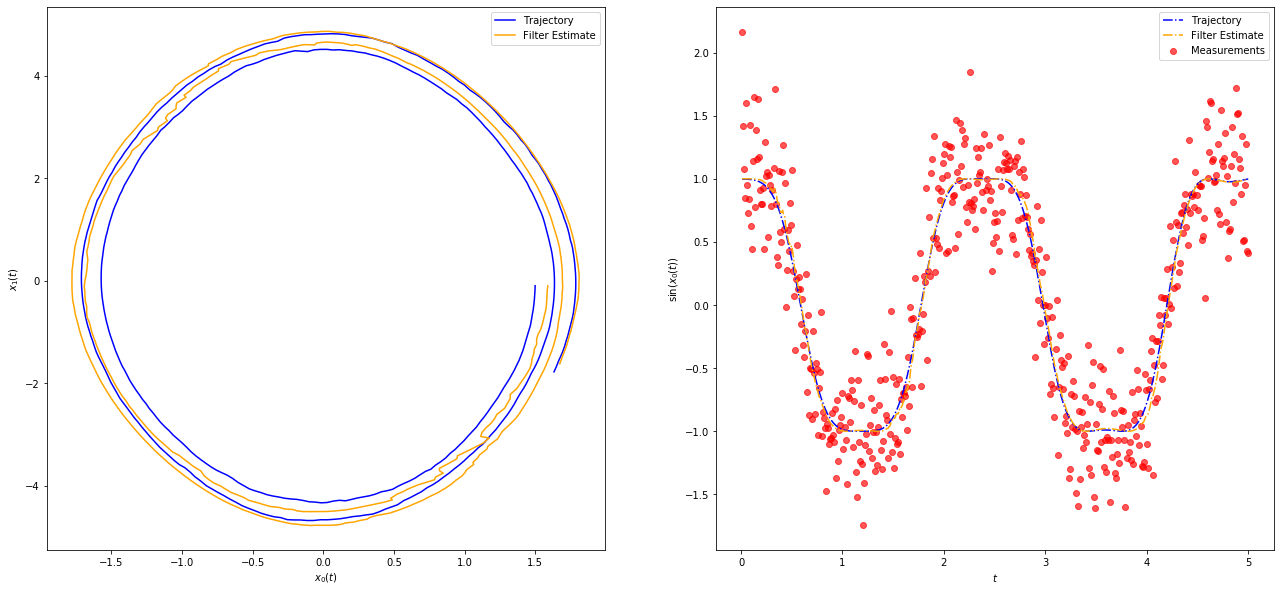

In [16]:
plot(timeline, observations, states, "Trajectory", pf_m, "Filter Estimate")

In [17]:
rmse_pf = rmse(pf_m[:, :1], states[:, :1])
print(f"PF RMSE: {rmse_pf}")

PF RMSE: 0.07992204807089615


## Particle Smoother

In [18]:
def particle_smoother(pf_states, g, Q, dt, R, n_trajectories, random_state):
    steps, M, n_particles = pf_states.shape
    pf_bs_states = np.empty((steps, 2, n_trajectories))
    
    ind = random_state.choice(n_particles, n_trajectories)
    smoothed_states = pf_states[-1][:, ind]
    pf_bs_states[-1] = smoothed_states
    
    frozen_dist = stats.multivariate_normal(mean=[0., 0.], cov=Q)
    
    for i in tqdm.trange(steps-2, -1, -1):
        filtered_state = pf_states[i]
        mu = np.stack([filtered_state[0, :] + filtered_state[1, :] * dt,
                       filtered_state[1, :] - g * np.sin(filtered_state[0, :]) * dt], axis=1)
        for k in range(n_trajectories):
            smoothed_state = smoothed_states[:, k]
            diff = smoothed_state.reshape(1, M) - mu
            w = frozen_dist.pdf(diff)
            w = normalise(w)
            ind = random_state.choice(n_particles, 1, p=w)
            smoothed_state = filtered_state[:, ind].flatten()
            smoothed_states[:, k] = smoothed_state
            pf_bs_states[i, :, k] = smoothed_state
            
    return pf_bs_states

In [19]:
pf_bs_states = particle_smoother(filtered_states, g, Q, dt, R, 100, random_state)

100%|██████████| 499/499 [00:04<00:00, 114.94it/s]


In [20]:
pf_bs_m = np.mean(pf_bs_states, axis=-1)

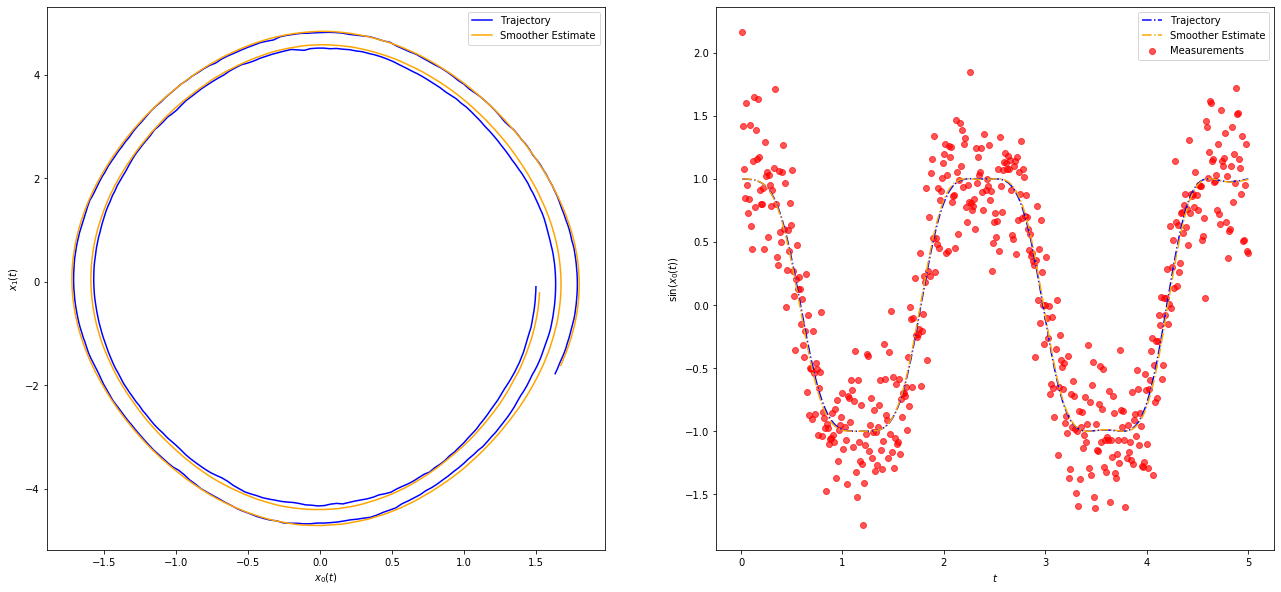

In [21]:
plot(timeline, observations, states, "Trajectory", pf_bs_m, "Smoother Estimate")

In [22]:
rmse_pf_bs = rmse(pf_bs_m[:, :1], states[:, :1])
print(f"PF-BS RMSE: {rmse_pf_bs}")

PF-BS RMSE: 0.030590265720468888
